In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [11]:
titanic = pd.read_csv("titanic_train.csv")

In [12]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,333,0,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S
1,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S
2,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.3750,NaN,S
3,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
4,406,0,2,"Gale, Mr. Shadrach",male,34.0,1,0,28664,21.0000,NaN,S


In [13]:
titanic["Embarked"].value_counts()

Embarked
S    515
C    136
Q     59
Name: count, dtype: int64

In [14]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          548
Embarked         2
dtype: int64

In [15]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].mode()[0])

titanic["Fare"] = titanic["Fare"].fillna(titanic['Fare'].median())

titanic["Sex"] = titanic["Sex"].map({'male':0, "female":1})

titanic["Embarked"] = titanic["Embarked"].astype('category').cat.codes

In [16]:
titanic["Embarked"].value_counts()

Embarked
2    517
0    136
1     59
Name: count, dtype: int64

In [17]:
titanic["Familysize"] = titanic["SibSp"] + titanic["Parch"]+ 1

titanic["Isalone"] = (titanic['Familysize'] ==1).astype(int)

titanic["HasCabin"] = titanic['Cabin'].notnull().astype(int)

titanic["Title"] = titanic['Name'].str.extract('([A-Za-z]+)\.', expand=False).map(
    {'Mr':0,'Miss':1, 'Mrs':2, 'Master': 3, 'Rare':4}
).fillna(4)

titanic['Pclass_Fare'] = titanic['Pclass'] * titanic['Fare']

titanic['Age_Fare'] = titanic["Age"] * titanic["Fare"]

In [18]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Familysize,Isalone,HasCabin,Title,Pclass_Fare,Age_Fare
0,333,0,1,"Graham, Mr. George Edward",0,38.0,0,1,PC 17582,153.4625,C91,2,2,0,1,0.0,153.4625,5831.5750
1,282,0,3,"Olsson, Mr. Nils Johan Goransson",0,28.0,0,0,347464,7.8542,NaN,2,1,1,0,0.0,23.5626,219.9176
2,148,0,3,"Ford, Miss. Robina Maggie ""Ruby""",1,9.0,2,2,W./C. 6608,34.3750,NaN,2,5,0,0,1.0,103.1250,309.3750
3,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.5500,C103,2,1,1,1,1.0,26.5500,1539.9000
4,406,0,2,"Gale, Mr. Shadrach",0,34.0,1,0,28664,21.0000,NaN,2,2,0,0,0.0,42.0000,714.0000


In [19]:

X = titanic[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Familysize', 'Isalone', 'HasCabin', 'Title', 'Pclass_Fare', 'Age_Fare']]
y = titanic['Survived']

<Axes: ylabel='count'>

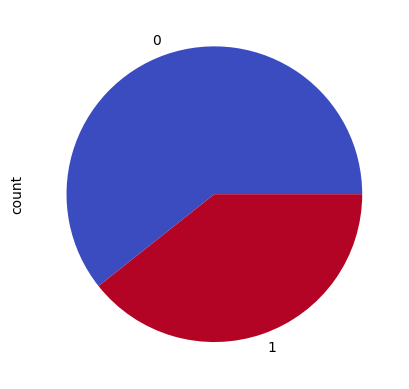

In [20]:
titanic["Survived"].value_counts().plot(kind='pie', colormap='coolwarm')

In [21]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

In [22]:
y_resampled.value_counts()

Survived
0    432
1    432
Name: count, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [25]:
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=10, cv=3, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200, ...]}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.82
